# Задача о Маятнике

Наша цель обучить несколько моделей для этой [задачи](https://gymnasium.farama.org/environments/classic_control/pendulum/):

## Подготовка данных

In [1]:
import gymnasium as gym

In [2]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)

In [3]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>

In [4]:
env.reset(seed=123, options={"low": -0.7, "high": 0.5})

(array([ 0.4123625 ,  0.91101986, -0.89235795], dtype=float32), {})

In [5]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Генеративная модель (end-to-end) (предсказываю положение через н секунд)

### Обучение

📟 Устройство: cuda
📦 Сбор данных с шумом (ветром)...
✅ Собрано 58500 пар с учётом 'ветра'
🧠 Обучение end-to-end модели...
Эпоха 0/100, Loss: 0.0148
Эпоха 10/100, Loss: 0.0038
Эпоха 20/100, Loss: 0.0038
Эпоха 30/100, Loss: 0.0037
Эпоха 40/100, Loss: 0.0037
Эпоха 50/100, Loss: 0.0036
Эпоха 60/100, Loss: 0.0036
Эпоха 70/100, Loss: 0.0036
Эпоха 80/100, Loss: 0.0036
Эпоха 90/100, Loss: 0.0035


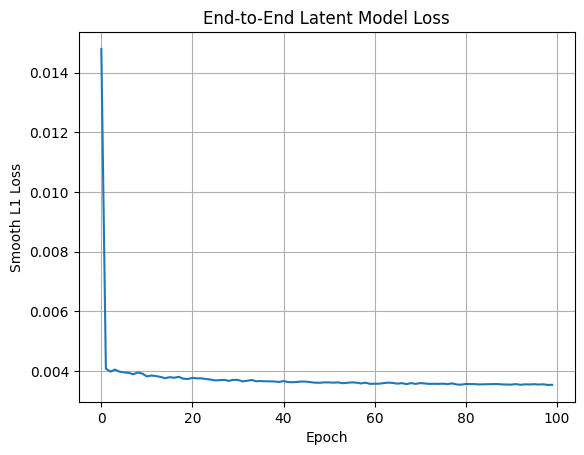

In [8]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

# ⚙️ Настройки
ENV_NAME = "Pendulum-v1"
N_FUTURE_STEPS = 5
LATENT_SIZE = 32
EPOCHS = 100
BATCH_SIZE = 64
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Устройство: {DEVICE}")

# 🎯 Среда
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]

# 📦 Сбор данных: [state_t → state_{t+N}] с "ветром"
print("📦 Сбор данных с шумом (ветром)...")
X_states = []
y_future_states = []
for _ in range(300):
    state, _ = env.reset()
    done = False
    ep_states = []
    while not done:
        ep_states.append(state)

        # 🎯 Сэмплируем действие и добавляем "ветер"
        action = env.action_space.sample()
        noise = np.random.normal(0, 0.2, size=action.shape)  # 0.2 — сила "ветра"
        noisy_action = np.clip(action + noise, env.action_space.low, env.action_space.high)

        state, _, terminated, truncated, _ = env.step(noisy_action)
        done = terminated or truncated

    if len(ep_states) > N_FUTURE_STEPS:
        for i in range(len(ep_states) - N_FUTURE_STEPS):
            X_states.append(ep_states[i])
            y_future_states.append(ep_states[i + N_FUTURE_STEPS])
env.close()
print(f"✅ Собрано {len(X_states)} пар с учётом 'ветра'")

# ⚖️ Нормализация
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_states)
y_scaled = scaler_y.fit_transform(y_future_states)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).to(DEVICE)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 🧱 Модели
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
    def forward(self, z):
        return self.model(z)

class Predictor(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
    def forward(self, z):
        return self.model(z)

# 🔧 Создаем модель
encoder = Encoder(state_size, LATENT_SIZE).to(DEVICE)
decoder = Decoder(LATENT_SIZE, state_size).to(DEVICE)
predictor = Predictor(LATENT_SIZE).to(DEVICE)

params = list(encoder.parameters()) + list(decoder.parameters()) + list(predictor.parameters())
optimizer = optim.Adam(params, lr=LR)
criterion = nn.SmoothL1Loss()

# 🧠 Обучение
print("🧠 Обучение end-to-end модели...")
losses = []
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    predictor.train()

    epoch_loss = 0
    for x_batch, y_batch in loader:
        latent_t = encoder(x_batch)
        latent_future = predictor(latent_t)
        y_pred = decoder(latent_future)

        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Эпоха {epoch}/{EPOCHS}, Loss: {avg_loss:.4f}")

# 📈 График потерь
plt.plot(losses)
plt.title("End-to-End Latent Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Smooth L1 Loss")
plt.grid(True)
plt.show()

# 📊 Предсказания
encoder.eval()
predictor.eval()
decoder.eval()

with torch.no_grad():
    latent_now = encoder(X_tensor)
    latent_pred = predictor(latent_now)
    preds_scaled_latent = decoder(latent_pred).cpu().numpy()
    preds_latent = scaler_y.inverse_transform(preds_scaled_latent)
    y_true_latent = scaler_y.inverse_transform(y_tensor.cpu().numpy())

# 📦 Сохраняем для сравнения
y_true_latent = y_true_latent
preds_latent = preds_latent

# Прямая модель


📟 Устройство: cuda
📦 Сбор данных для прямой модели...
🧠 Обучение прямой модели...
Эпоха 0/50, Loss: 0.0127
Эпоха 10/50, Loss: 0.0035
Эпоха 20/50, Loss: 0.0034
Эпоха 30/50, Loss: 0.0034
Эпоха 40/50, Loss: 0.0034


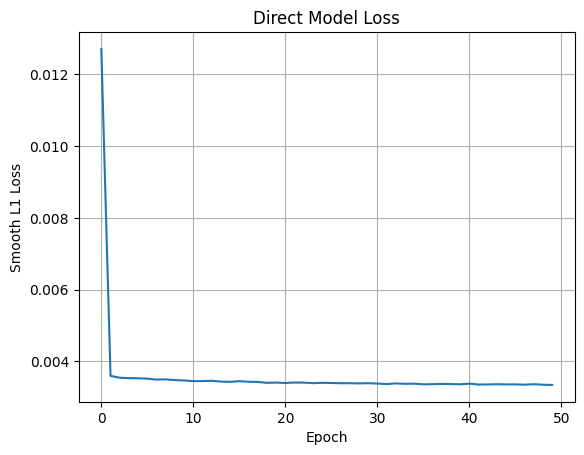


📉 MSE на обучающих данных (прямая модель): 0.0489
  ▶️ MSE cos(θ): 0.0019
  ▶️ MSE sin(θ): 0.0021
  ▶️ MSE θ̇: 0.1427

🎯 Пример предсказания (прямая модель):
Предсказано (через 5 шагов): [ 0.91863143 -0.4102174   0.6266326 ]
Истинное значение: [ 0.93103206 -0.36493737  0.88571763]
Средняя ошибка: 0.0231


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ⚙️ Параметры
ENV_NAME = "Pendulum-v1"
N_FUTURE_STEPS = 5
EPOCHS_DIRECT = 50
BATCH_SIZE = 32
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Устройство: {DEVICE}")

# 🎯 Создаём среду
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]

# 📦 Сбор данных: [state_t → state_{t+N}]
print("📦 Сбор данных для прямой модели...")
X_states = []
y_future_states = []

for _ in range(300):
    state, _ = env.reset()
    done = False
    ep_states = []

    while not done:
        ep_states.append(state)
        action = env.action_space.sample()
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    if len(ep_states) > N_FUTURE_STEPS:
        for i in range(len(ep_states) - N_FUTURE_STEPS):
            X_states.append(ep_states[i])
            y_future_states.append(ep_states[i + N_FUTURE_STEPS])

env.close()
#print(f"✅ Собрано {len(X_states)} пар [state_t → state_{t+N}]")

# ⚖️ Нормализация входов и выходов
scaler_X_direct = StandardScaler()
scaler_y_direct = StandardScaler()

X_scaled = scaler_X_direct.fit_transform(X_states)
y_scaled = scaler_y_direct.fit_transform(y_future_states)

X_tensor_direct = torch.tensor(X_scaled, dtype=torch.float32).to(DEVICE)
y_tensor_direct = torch.tensor(y_scaled, dtype=torch.float32).to(DEVICE)

# 🧠 Модель прямого предсказания
class DirectModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.model(x)

model_direct = DirectModel(state_size, state_size).to(DEVICE)
optimizer = optim.Adam(model_direct.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

# 🔧 Обучение
print("🧠 Обучение прямой модели...")
losses = []
for epoch in range(EPOCHS_DIRECT):
    perm = torch.randperm(len(X_tensor_direct))
    epoch_loss = 0
    for i in range(0, len(X_tensor_direct), BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        batch_X = X_tensor_direct[idx]
        batch_y = y_tensor_direct[idx]

        pred = model_direct(batch_X)
        loss = criterion(pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (len(X_tensor_direct) // BATCH_SIZE)
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Эпоха {epoch}/{EPOCHS_DIRECT}, Loss: {avg_loss:.4f}")

# 📈 График потерь
plt.plot(losses)
plt.title("Direct Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Smooth L1 Loss")
plt.grid(True)
plt.show()

# 📦 Сохраняем всё для сравнения
with torch.no_grad():
    preds_scaled_direct = model_direct(X_tensor_direct).cpu().numpy()
    preds_direct = scaler_y_direct.inverse_transform(preds_scaled_direct)
    y_true_direct = scaler_y_direct.inverse_transform(y_tensor_direct.cpu().numpy())

# 📊 Оценка
mse_total = mean_squared_error(y_true_direct, preds_direct)
print(f"\n📉 MSE на обучающих данных (прямая модель): {mse_total:.4f}")

components = ['cos(θ)', 'sin(θ)', 'θ̇']
for i, comp in enumerate(components):
    comp_mse = mean_squared_error(y_true_direct[:, i], preds_direct[:, i])
    print(f"  ▶️ MSE {comp}: {comp_mse:.4f}")

# 🔍 Пример предсказания
idx = np.random.randint(0, len(X_tensor_direct))
pred_real = preds_direct[idx]
true_real = y_true_direct[idx]
error = np.mean((pred_real - true_real) ** 2)

print("\n🎯 Пример предсказания (прямая модель):")
print(f"Предсказано (через {N_FUTURE_STEPS} шагов): {pred_real}")
print(f"Истинное значение: {true_real}")
print(f"Средняя ошибка: {error:.4f}")

### Метрики

In [10]:
from sklearn.metrics import mean_squared_error

components = ['cos(θ)', 'sin(θ)', 'θ̇']

print("\n🔍 Сравнение латентной и прямой модели по MSE:")

# Общая ошибка
mse_latent = mean_squared_error(y_true_latent, preds_latent)
mse_direct = mean_squared_error(y_true_direct, preds_direct)

print(f"\n📦 Общая MSE:")
print(f"  🔹 Латентная модель: {mse_latent:.6f}")
print(f"  🔸 Прямая модель:   {mse_direct:.6f}\n")

# По компонентам
print("📦 MSE по компонентам:")
for i, comp in enumerate(components):
    mse_l = mean_squared_error(y_true_latent[:, i], preds_latent[:, i])
    mse_d = mean_squared_error(y_true_direct[:, i], preds_direct[:, i])
    print(f"  ▶️ {comp}:")
    print(f"     🔹 Латентная модель: {mse_l:.6f}")
    print(f"     🔸 Прямая модель:   {mse_d:.6f}")


🔍 Сравнение латентной и прямой модели по MSE:

📦 Общая MSE:
  🔹 Латентная модель: 0.048460
  🔸 Прямая модель:   0.048909

📦 MSE по компонентам:
  ▶️ cos(θ):
     🔹 Латентная модель: 0.001861
     🔸 Прямая модель:   0.001882
  ▶️ sin(θ):
     🔹 Латентная модель: 0.002440
     🔸 Прямая модель:   0.002101
  ▶️ θ̇:
     🔹 Латентная модель: 0.141080
     🔸 Прямая модель:   0.142747
